<a href="https://colab.research.google.com/github/PBGLMichaelHall/Tensorflow/blob/main/HammingDistance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Please refer to original blog for more information
# https://towardsdatascience.com/machine-learning-in-bioinformatics-genome-geography-d1b1dbbfb4c2
!pip install pysam

In [ ]:
import pandas as pd
from pysam import VariantFile
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

plt.style.use('ggplot')


In [ ]:
samples = pd.read_csv('samples_subset.tsv', sep='\t')
vcf = VariantFile('freebayes~bwa~IRGSP-1.0~all-mutants-minus-S14~QUAL1000-S15-HOMREF.vcf.gz')



In [ ]:
samples = samples[samples['Sample name'].isin(list(vcf.header.samples))]
samples['Superpopulation code'].value_counts()

BB    8
AA    5
RR    1
Name: Superpopulation code, dtype: int64

In [ ]:
samples.to_csv('samples_subset.tsv', sep='\t', index=False)
num_samples = len(samples)
num_samples

14

Compute Hamming Distance Between Subset Samples

In [ ]:


num_mismatches = np.zeros((num_samples, num_samples))
num_snps = 0



In [ ]:


for rec in vcf.fetch():
    all_homref = True
    tmp_mismatches = np.zeros((num_samples, num_samples))
    for i in range(num_samples):
        if rec.samples[i]['GT'] != (0,0):
            all_homref = False
        for j in range(i, num_samples):
            if (rec.samples[i]['GT'] != rec.samples[j]['GT']) & (rec.samples[i]['GT'] != rec.samples[j]['GT'][::-1]):
                tmp_mismatches[i,j] += 1
    if not all_homref:
        num_mismatches += tmp_mismatches
        num_snps += 1



In [ ]:


ham_dist = num_mismatches / num_snps
ham_dist = np.triu(ham_dist) + np.tril(ham_dist.T) # Make matrix balanced
np.savetxt('ham_dist.txt', ham_dist, delimiter='\t', fmt='%1.3f')



Load pre-computed files

In [ ]:
vcf = VariantFile('CHR6.vcf.gz')
samples_subset = pd.read_csv('samples_subset.tsv', sep='\t')
ham_dist = np.loadtxt('ham_dist.txt')

In [ ]:
sorterIndex = dict(zip(list(vcf.header.samples), range(len(list(vcf.header.samples)))))
samples_subset['Rank'] = samples_subset['Sample name'].map(sorterIndex)
samples_subset.sort_values('Rank', inplace=True)
samples_subset.drop('Rank', axis=1, inplace=True)

In [ ]:
df = pd.DataFrame(ham_dist)
print(df)


       0      1      2      3      4      5      6      7      8      9   \
0   0.000  0.936  0.905  0.924  0.928  0.852  0.883  0.873  0.877  0.876   
1   0.936  0.000  0.137  0.117  0.112  0.165  0.156  0.139  0.152  0.160   
2   0.905  0.137  0.000  0.146  0.111  0.178  0.177  0.160  0.174  0.189   
3   0.924  0.117  0.146  0.000  0.118  0.166  0.170  0.150  0.159  0.172   
4   0.928  0.112  0.111  0.118  0.000  0.152  0.141  0.128  0.139  0.154   
5   0.852  0.165  0.178  0.166  0.152  0.000  0.122  0.117  0.108  0.125   
6   0.883  0.156  0.177  0.170  0.141  0.122  0.000  0.113  0.104  0.093   
7   0.873  0.139  0.160  0.150  0.128  0.117  0.113  0.000  0.110  0.118   
8   0.877  0.152  0.174  0.159  0.139  0.108  0.104  0.110  0.000  0.108   
9   0.876  0.160  0.189  0.172  0.154  0.125  0.093  0.118  0.108  0.000   
10  0.883  0.152  0.172  0.165  0.143  0.116  0.086  0.103  0.102  0.094   
11  0.896  0.131  0.145  0.154  0.118  0.136  0.120  0.116  0.123  0.132   
12  0.869  0

In [ ]:


df[['sample', 'superpop', 'pop']] = samples_subset[['Sample name', 'Superpopulation code', 'Population code']].reset_index(drop=True)



In [ ]:


df = df.rename(columns=dict(zip(range(100), list(samples_subset['Sample name']))))
df = df.set_index('sample')



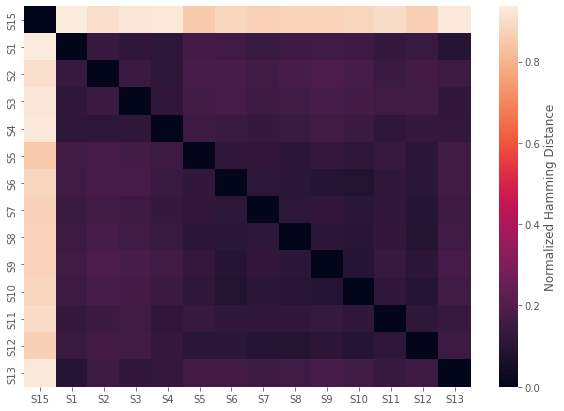

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(df.drop(['superpop', 'pop'], axis=1), cbar_kws={'label': 'Normalized Hamming Distance'})
plt.ylabel('')
plt.show()


Dimensionality Reduction with tSNE

In [ ]:


tsne = TSNE(n_components=2)




In [ ]:


transformed = tsne.fit_transform(df.drop(['superpop', 'pop'], axis=1))
print(transformed)



[[ 234.58688   -93.41102 ]
 [-169.52255  -308.96298 ]
 [ 122.91864   126.914986]
 [ -55.38388   196.7315  ]
 [  22.711143  -26.38743 ]
 [-402.92844   108.38526 ]
 [ -70.48632   407.20782 ]
 [-195.04059    71.98218 ]
 [  64.87467  -245.88277 ]
 [-265.76523   290.57553 ]
 [-351.8763   -118.682365]
 [-139.28339  -111.13996 ]
 [ 322.69992   132.22894 ]
 [ 150.96327   336.56186 ]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:


df_tsne = pd.DataFrame(transformed, columns=['C1', 'C2'])
df_tsne[['superpop', 'pop']] = df[['superpop', 'pop']].reset_index(drop=True)
print(df_tsne)



            C1          C2 superpop pop
0   234.586884  -93.411018       RR  RR
1  -169.522552 -308.962982       AA  AA
2   122.918640  126.914986       AA  AA
3   -55.383881  196.731506       AA  AA
4    22.711143  -26.387430       AA  AA
5  -402.928436  108.385262       BB  BB
6   -70.486320  407.207825       BB  BB
7  -195.040588   71.982178       BB  BB
8    64.874672 -245.882767       BB  BB
9  -265.765228  290.575531       BB  BB
10 -351.876312 -118.682365       BB  BB
11 -139.283386 -111.139961       BB  BB
12  322.699921  132.228943       BB  BB
13  150.963272  336.561859       AA  AA


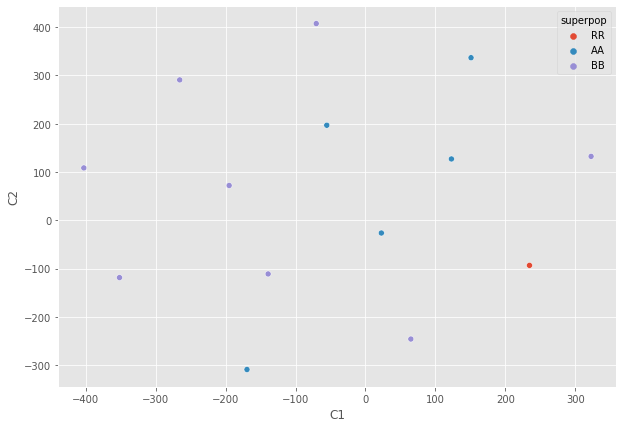

In [ ]:


plt.figure(figsize=(10,7))
sns.scatterplot(x='C1', y='C2', data=df_tsne, hue='superpop')
plt.show()



In [ ]:



X, y = df.drop(['superpop', 'pop'], axis=1), df['superpop']






In [ ]:


rf = RandomForestClassifier()
nb = MultinomialNB()
knn = KNeighborsClassifier()
lgr = LogisticRegression(multi_class='multinomial')






In [ ]:


classifiers = [rf, nb, knn, lgr]
scores = np.array([])
k = 5
for clf in classifiers:
    scores = np.append(scores, cross_val_score(clf, X, y, cv=k)[:])
classifier_labels = []
for label in ['RF', 'NB', 'KNN', 'LGR']:
    classifier_labels += [label] * k



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


In [ ]:
df_scores = pd.DataFrame([scores, classifier_labels], index=['Accuracy', 'Classifier'])
df_scores = df_scores.T
print(df_scores)

    Accuracy Classifier
0   0.666667         RF
1        1.0         RF
2        1.0         RF
3        1.0         RF
4        1.0         RF
5   0.333333         NB
6   0.666667         NB
7   0.666667         NB
8   0.666667         NB
9        0.5         NB
10  0.666667        KNN
11       1.0        KNN
12       1.0        KNN
13       1.0        KNN
14       1.0        KNN
15  0.333333        LGR
16  0.666667        LGR
17  0.666667        LGR
18  0.666667        LGR
19       0.5        LGR


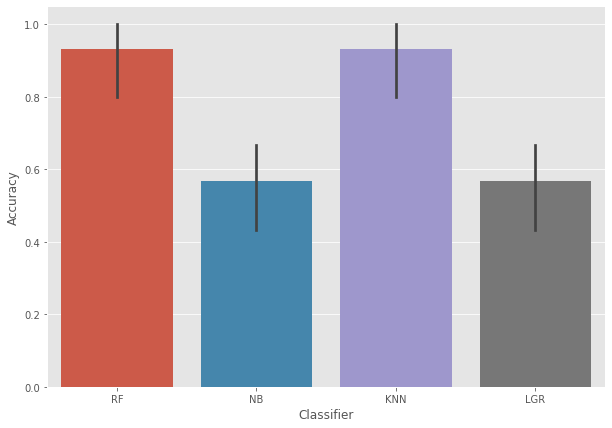

In [ ]:


plt.figure(figsize=(10,7))
sns.barplot(x='Classifier', y='Accuracy', data=df_scores)
plt.show()

